# 🏥 Analyzing **Health** and **Poverty** Data Across US Counties (2022)

## 🅿️2️⃣ Project Part 3 - Machine Learning

## 👥 Team Members  
- **Shreya Gupta** (*gshrey*)  
- **Vaishnavi Venkataraghavan** (*vaishven*)  
- **James Gair** (*jgair*)  

## 📂 Data Sources  
- 🏥 1. **CDC PLACES Health Data**  
- 📈 2. **U.S. Census Bureau ACS 5-Year Estimates**   


## ❓ Research Questions  
1. **How does the relationship between poverty rates and health outcomes vary across U.S. counties and do high-poverty areas experience significantly worse health outcomes compared to wealthier counties?**  

2. **What health risk behaviors are most prevalent in counties with higher poverty rates and do these behaviors correlate with disease prevalence?**

3. **How do poverty rates correlate with health disparities among people of color across different states?** 

## Our Chosen Machine Learning Approach: **K-Means and Agglomerative Clustering**

### Objective
We use our cleaned dataset (`complete_data.csv`), which was processed back in Project Part 1. We will continue gathering insights into the key health and poverty categories that we explored with our **Real-World Questions**, which are **Health Outcomes** *(Like Obesity, Diabetes, etc.)*, **Health-Risk Behaviors** *(Like Smoking, Binge Drinking, etc.)* and **Racial Groups** *(Like African Americans, Asians, etc.)* and its relationship with **Poverty.**

### Why Clustering?

We are opting to use **clustering** as our machine learning method for this project. Our dataset includes primarily continuous numeric variables such as the prevalence of various health outcomes, health risk behaviors and racial poverty rates across U.S. counties. Since there are no existing binary columns with labels like *“High Risk of Obesity”* vs *“Low Risk of Obesity”*, etc., classification methods are not an ideal fit for our analysis.

### Why *not* Classification? Can't we make our own target binary variable?

We briefly explored using **chi-squared tests** to evaluate potential relationships and converting some of our columns into **binary variables** in the **Inferential Statistics** section while answering our third research question in our **Project Part 2: Analysis**. However, the results from those tests were ***not* statistically significant**. This suggests that reducing our continuous data into binary categories may oversimplify the patterns we're trying to understand and may not produce meaningful predictive models.

Given this context, clustering provides a more suitable approach. As an **unsupervised** learning method, clustering will allow us to group counties or states based on shared characteristics in their poverty and health/racial profiles without needing a predefined label. This can help us discover **natural groupings** and potentially reveal regional or demographic trends that are not obvious from individual variables alone.

### Methodology

We plan to apply two clustering techniques: **K-Means Clustering** and **Agglomerative (Hierarchical) Clustering**. K-Means will allow us to divide the dataset into a fixed number of groups based on similarity across selected features. It’s a fast and interpretable method that works well with the type of continuous data in our project. In parallel, we will use Agglomerative Clustering to build a hierarchy of clusters, which we can visualize with dendrograms to see how counties or states relate to one another. Using both methods will give us different perspectives on the structure of our data and help validate the groupings we observe.

Ultimately, clustering will allow us to explore patterns across health outcomes and racial poverty rates without forcing arbitrary thresholds or labels, making it a valuable tool for identifying insights in this context.

## Data Pre-processing

### Load Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('default')

### Set Working Directory

In [2]:
import os

try:
    current_dir = os.path.dirname(__file__)
except NameError:
    current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "data")

### Data Loading and Basic Setup
We load the merged and cleaned health data from `complete_data.csv`

In [3]:
# Load the combined and cleaned dataset that was produced in Part I.
df_full = pd.read_csv(os.path.join(data_dir, "complete_data.csv"))
print('Total number of rows in the dataset:', df_full.shape[0])

df = df_full.copy()  # Use df as the working copy

Total number of rows in the dataset: 113100


### Frameworking Pivot Tables for Clustering

We will be creating pivot tables for **Health Outcomes**, **Health-Risk Behaviors**, and **Racial Poverty**. These features were the **primary features** we examined in each of our **research questions**, respectively. 

#### Why Pivot?

**A refresher from our previous analysis:** 

- **Health Outcomes** and **Health-Risk Behaviors** are **categories** within the Category column in our CDC PLACES dataset. 
- The **Health Measure** columns contains labels that have Outcomes (such as Obesity, Diabetes, etc.)/ Behaviors (such as Smoking, Binge-Drinking) with corresponding affected population percentages in the **Pop Percent** column. 
- There are **multiple** Health Measures and Categories for each County, and Poverty percentages are **repeated** because of our initial merge of Census Data with CDC PLACES dataset in **Project Part 1.** 
  
Therefore, pivoting these tables so that **State**, **County**, and **Poverty Percentages** only appear *once* can help us gain better **health-focused perspectives** for each County. 

In [4]:
def pivot(df, target):
    # Filter data for category
    health_outcomes_df = df[df["Category"] == target]

    # Pivot the data so each Health Measure becomes a column with Pop_Percent as values
    pivot_df = health_outcomes_df.pivot_table(index=["County", "State", "BP_ Total%"], 
                                            columns="Health_Measure", 
                                            values="Pop_Percent").reset_index()

    return pivot_df

In [5]:
def pivot_race(df, target):
    # Filter data for category
    health_outcomes_df = df[df["Category"] == target]

    # Pivot the data so each Health Measure becomes a column with Pop_Percent as values
    pivot_df = health_outcomes_df.pivot_table(index=["County", "State", "BP_ African American%", "BP_ Asian%", "BP_ Hispanic or Latino%", "BP_ White%"], 
                                            columns="Health_Measure", 
                                            values="Pop_Percent").reset_index()

    return pivot_df

### Create Pivot Tables based on Research Question Features

We are creating **three** pivot tables for our dataset.

- Health Outcomes as columns alongside Total Poverty Percentages for each US County.
- Health Risk-Behaviors as columns alongside Total Poverty Percentages for each US County.
- Health Outcomes as columns alongside Racial Poverty Percentages for each US County.

In [6]:
df_pivot_disease = pivot(df_full, "Health Outcomes")
print('Health Outcomes Pivot shape:', df_pivot_disease.shape)
display(df_pivot_disease.head())
print(df_pivot_disease.isna().sum()) # Missing values

df_pivot_behav = pivot(df_full, "Health Risk Behaviors")
print("---")
print('Health Risk Behaviors Pivot shape:', df_pivot_behav.shape)
display(df_pivot_behav.head())
print(df_pivot_behav.isna().sum())

# Create pivot table
df_pivot_racial = pivot_race(df_full, "Health Outcomes")
print("---")
print('Racial Disease Pivot shape:', df_pivot_racial.shape)
display(df_pivot_racial.head())
print(df_pivot_racial.isna().sum())

Health Outcomes Pivot shape: (2942, 15)


Health_Measure,County,State,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
0,Abbeville,South Carolina,15.90,23.40,26.30,7.40,6.80,6.20,10.30,22.40,11.70,35.90,30.60,38.70,3.80
1,Acadia,Louisiana,23.70,18.90,27.50,8.90,6.90,7.10,10.90,28.40,12.40,39.10,33.60,36.80,4.10
2,Accomack,Virginia,15.90,24.30,29.00,8.90,6.90,6.60,11.60,24.90,13.60,36.90,32.40,44.00,4.00
3,Ada,Idaho,8.80,17.70,21.80,4.60,7.40,5.10,10.00,25.10,7.70,25.90,26.30,28.70,2.50
4,Adair,Iowa,10.10,11.10,24.10,6.30,7.10,5.80,9.80,19.50,9.80,28.70,28.40,41.90,3.00


Health_Measure
County                            0
State                             0
BP_ Total%                        0
All Teeth Lost                    0
Arthritis                         0
COPD                              0
Cancer (non-skin) or Melanoma     0
Coronary Heart Disease            0
Current Asthma                    0
Depression                        0
Diabetes                          0
High Blood Pressure              62
High Cholesterol                 62
Obesity                           0
Stroke                            0
dtype: int64
---
Health Risk Behaviors Pivot shape: (2942, 7)


Health_Measure,County,State,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
0,Abbeville,South Carolina,15.90,17.80,17.60,25.60,38.30
1,Acadia,Louisiana,23.70,18.70,20.80,31.40,38.00
2,Accomack,Virginia,15.90,16.20,21.70,29.70,38.10
3,Ada,Idaho,8.80,17.80,11.50,17.60,30.60
4,Adair,Iowa,10.10,23.70,16.60,25.70,33.20


Health_Measure
County                       0
State                        0
BP_ Total%                   0
Binge Drinking               0
Current Cigarette Smoking    0
Physical Inactivity          0
Short Sleep Duration         0
dtype: int64
---
Racial Disease Pivot shape: (2942, 18)


Health_Measure,County,State,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
0,Abbeville,South Carolina,28.90,0.00,3.50,10.20,23.40,26.30,7.40,6.80,6.20,10.30,22.40,11.70,35.90,30.60,38.70,3.80
1,Acadia,Louisiana,41.70,0.00,33.40,18.00,18.90,27.50,8.90,6.90,7.10,10.90,28.40,12.40,39.10,33.60,36.80,4.10
2,Accomack,Virginia,23.60,20.80,23.80,10.50,24.30,29.00,8.90,6.90,6.60,11.60,24.90,13.60,36.90,32.40,44.00,4.00
3,Ada,Idaho,22.40,12.70,10.70,8.10,17.70,21.80,4.60,7.40,5.10,10.00,25.10,7.70,25.90,26.30,28.70,2.50
4,Adair,Iowa,40.90,0.00,0.00,10.30,11.10,24.10,6.30,7.10,5.80,9.80,19.50,9.80,28.70,28.40,41.90,3.00


Health_Measure
County                            0
State                             0
BP_ African American%             0
BP_ Asian%                        0
BP_ Hispanic or Latino%           0
BP_ White%                        0
All Teeth Lost                    0
Arthritis                         0
COPD                              0
Cancer (non-skin) or Melanoma     0
Coronary Heart Disease            0
Current Asthma                    0
Depression                        0
Diabetes                          0
High Blood Pressure              62
High Cholesterol                 62
Obesity                           0
Stroke                            0
dtype: int64


### Preprocessing Pipeline
The `preprocess_data` function takes a pivoted DataFrame and prepares it for clustering/ dimensionality reduction using PCA. It does the following:

- Removes non-feature columns like county/state names.
- Fills in any missing values. We impute the missing data in our **High Blood Pressure** and **High Cholesterol** columns by using the **median** as our strategy.
- Scales the data using **Standard Scaler** (so all features are on the same scale). It is crucial to scale our data as PCA (Principal Component Analysis) is very sensitive to scale. If one feature (say, **Stroke**) has a much larger range than another (say, **Obesity**), it will contribute disproportionately to the components — even if it’s not more important. Standard Scaler is also better than other scalers in our case, such as the **MinMax Scaler**, because the latter *draws attention to* outliers, which can skew our data.
- Uses PCA to reduce dimensionality while retaining **at least 90% of the variance**. We do this to remove noise, see clearer patterns in clustering, and increase computation speed. Any lower, and we run the risk of over-simplifying the data.
- Returns the transformed data along with the list of features and the processing pipeline.

*(Note: Our dataset has no categorical variables, **especially** after pivoting our data based on our research questions. Therefore, we will **not** be using categorical (or binary) imputation and pre-processing methods such as the **most-frequent** strategy, or **one-hot encoding** to make our dataset more machine readable)*

In [7]:
def preprocess_data(df_pivot, target):
    print(f"\n== Analysis of {target} ==")
    
    # Define the feature columns (exclude County, State, BP_ Total%)
    features = [col for col in df_pivot.columns if col not in ['County', 'State']]

    # Impute and scale features first
    pre_impute_scale = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    X_scaled = pre_impute_scale.fit_transform(df_pivot[features])

    # Determine optimal PCA components to retain at least 90% variance
    pca_full = PCA().fit(X_scaled)
    cum_var = np.cumsum(pca_full.explained_variance_ratio_)
    threshold = 0.90
    optimal_n = np.argmax(cum_var >= threshold) + 1 
    print(f"Optimal number of PCA components ({target}): {optimal_n}")

    # Build the pipeline using the optimal PCA dimensions
    pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=optimal_n, random_state=42))
    ])
    X_transformed = pipe.fit_transform(df_pivot[features])
    var_retained = np.sum(pipe.named_steps['pca'].explained_variance_ratio_) * 100
    print(f"Variance retained ({target}): {var_retained:.2f}%")
    return (X_transformed, features, pipe)


## K–Means Clustering on County Level Data

### Silhouette Analysis for k–Means Clustering

We perform **silhouette analysis** to help determine the **optimal number of clusters** (`k`) for K-Means clustering. The function below takes a PCA-transformed dataset and tests a range of cluster counts from **2 to 15**. For each `k`, it fits a K-Means model, assigns cluster labels, and calculates the silhouette score — a measure of how well each data point fits within its assigned cluster.

 Scores closer to 1 indicate well-separated clusters, while scores near 0 or negative suggest poor clustering. The function identifies the value of `k` that yields the highest silhouette score and plots all scores against their corresponding `k` values for visual inspection. 
 
 It then returns the optimal number of clusters to use. This is important because K-Means requires a predefined `k`, and silhouette analysis offers an objective way to choose a value that leads to meaningful, well-separated clusters.

In [8]:
def silhouette_analysis(X_transformed): 
    # Silhouette analysis for k-Means on disease pivot
    sil_scores = []
    for k_val in range(2, 16):
        km_temp = KMeans(n_clusters=k_val, random_state=42, n_init=10)
        labels_temp = km_temp.fit_predict(X_transformed)
        sil_scores.append(silhouette_score(X_transformed, labels_temp))
        print(f"For n_clusters = {k_val}, silhouette score (outcomes) = {sil_scores[-1]:.3f}")

    # Find the index of the max silhouette score
    optimal_k = list(range(2, 16))[np.argmax(sil_scores)]
    print(f"Optimal number of clusters (Health Outcomes): {optimal_k}")

    # Plot silhouette scores versus number of clusters
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 16), sil_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. n_clusters')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    plt.grid(True)
    plt.legend()
    plt.show()

    return optimal_k

### Retrieving K-Means Centroids & Clusters

We perform K-Means clustering using the optimal number of clusters determined previously (passed as `optimal_k`) on a PCA-transformed dataset (`X_transformed`). Below, we fit a K-Means model to the data and assigns each data point to a cluster. After clustering, it calculates and prints the silhouette score for the final model. The function then retrieves the **cluster centroids** — the average position of all points within each cluster in PCA space — and returns both the centroids and the cluster assignments for further analysis or visualization.

In [9]:
def perform_k_means_clustering(optimal_k, X_transformed):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_transformed)  
    print(f"k-Means Silhouette Score (Health Outcomes, k={optimal_k}): {silhouette_score(X_transformed, clusters):.3f}")

    # Get the cluster centroids in the optimal PCA space
    centroids = kmeans.cluster_centers_
    return centroids, clusters

### Aggregating Cluster Features for Insights

We can summarize and interpret the clusters created from K-Means by calculating the **average** values of all **numeric** features within each cluster. To better understand how each cluster differs from the dataset as a whole, we also calculate the **difference between each cluster's mean feature** values and the overall mean across all data points. This helps identify which clusters stand out and how — for example, whether a certain cluster has unusually high diabetes rates or lower poverty levels compared to the rest.

In [10]:
def pivot_table_aggregation(clusters, df_pivot, target, features):
    # Attach the cluster labels to pivot DataFrame
    df_pivot["Cluster"] = clusters

    # Group by the cluster labels and calculate mean values for each numeric column
    cluster_agg = df_pivot.groupby("Cluster").mean(numeric_only=True)

    print(f"=== Average Feature Values per Cluster ({target}) ===")
    display(cluster_agg)

    # Compare each cluster’s mean to the overall dataset mean
    overall_means = df_pivot[features].mean()
    cluster_diff = cluster_agg[features].sub(overall_means, axis="columns")

    print("=== Difference from Overall Mean ===")
    display(cluster_diff)

### Visualization of K–Means Clusters in PCA Space
We create a **2D visualization** of the clusters formed by K-Means using PCA-reduced data. If the original PCA uses **more than two components**, the function applies a second round of PCA to **reduce the data to two dimensions**, ensuring it can be plotted. It also transforms the cluster centroids into this 2D space so they can be displayed alongside the data points.

In [11]:
def visualize_clusters_PCA(pipe, X_transformed, centroids, clusters, optimal_k, target):
    # Visualisation for behaviour pivot: reduce to 2D if needed.
    if pipe.named_steps['pca'].n_components_ != 2:
        pca_vis = PCA(n_components=2, random_state=42)
        X_vis = pca_vis.fit_transform(X_transformed)
        # Transform cluster centroids to the 2D visualization space.
        centroids_vis = pca_vis.transform(centroids)
        print(f"Visualization PCA Explained Variance Ratio ({target}):", pca_vis.explained_variance_ratio_)
    else:
        X_vis = X_transformed
        centroids_vis = centroids

    plt.figure(figsize=(12, 6))
    for i in range(optimal_k):
        plt.scatter(
            X_vis[clusters == i, 0], 
            X_vis[clusters == i, 1],
            label=f'Cluster {i}',
            alpha=0.7, edgecolor='k'
        )
    plt.scatter(centroids_vis[:, 0], centroids_vis[:, 1], s=200, marker='X', c='red', label='Centroids')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'K–Means Clusters on {target} Pivot')
    plt.legend()
    plt.show()

## 1️⃣ Clustering on Health Outcomes Pivot Table

**Health Outcomes** is a primary category referred to in our first research question:

*How does the relationship between poverty rates and **health outcomes** vary across U.S. counties and do high-poverty areas experience significantly worse health outcomes compared to wealthier counties?*

Pivot table we'll be using for analysis: **Health Outcomes as columns alongside Total Poverty Percentages for each US County `df_pivot_disease`.**

### Preprocess data using pipeline

In [12]:
X_transformed_disease, features_disease, pipe_disease = preprocess_data(df_pivot_disease, "Health Outcomes")


== Analysis of Health Outcomes ==
Optimal number of PCA components (Health Outcomes): 5
Variance retained (Health Outcomes): 90.76%


The optimal number of principal components needed to retain meaningful information from the original data is **five**. This means that instead of working with all original health outcome variables, we can reduce the dataset to just five new dimensions (components) without losing much important information. Specifically, these five components capture **90.76% of the total variance in the original data** — a strong indication that most of the underlying patterns and structure are preserved.

### Silhouette Analysis for k–Means Clustering

For n_clusters = 2, silhouette score (outcomes) = 0.379
For n_clusters = 3, silhouette score (outcomes) = 0.256
For n_clusters = 4, silhouette score (outcomes) = 0.251
For n_clusters = 5, silhouette score (outcomes) = 0.237
For n_clusters = 6, silhouette score (outcomes) = 0.234
For n_clusters = 7, silhouette score (outcomes) = 0.214
For n_clusters = 8, silhouette score (outcomes) = 0.221
For n_clusters = 9, silhouette score (outcomes) = 0.211
For n_clusters = 10, silhouette score (outcomes) = 0.207
For n_clusters = 11, silhouette score (outcomes) = 0.202
For n_clusters = 12, silhouette score (outcomes) = 0.201
For n_clusters = 13, silhouette score (outcomes) = 0.197
For n_clusters = 14, silhouette score (outcomes) = 0.197
For n_clusters = 15, silhouette score (outcomes) = 0.195
Optimal number of clusters (Health Outcomes): 2


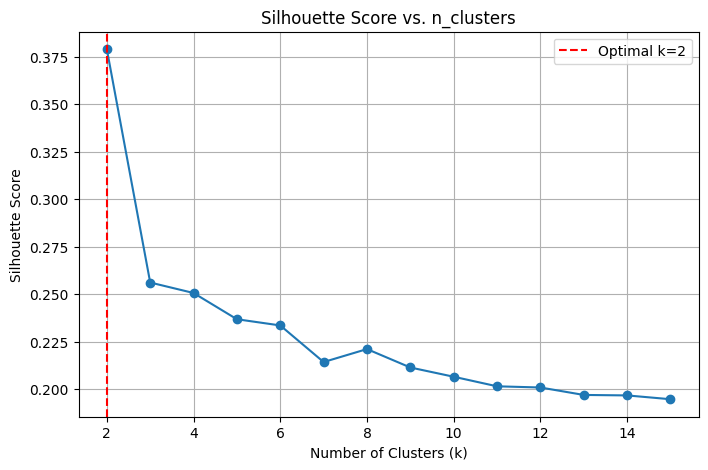

In [13]:
optimal_k_disease = silhouette_analysis(X_transformed_disease)

Among all tested values of k from **2 to 15**, the highest silhouette score was **0.379 when using 2 clusters**, making it the optimal number of clusters for this dataset. As k increases, the silhouette scores slightly decrease and remain relatively low and stable, suggesting that adding more clusters does not significantly improve the grouping and may even lead to overlapping or less distinct clusters.

### Retrieving K-Means Centroids & Clusters

In [14]:
centroids_disease, clusters_disease = perform_k_means_clustering(optimal_k_disease, X_transformed_disease)

k-Means Silhouette Score (Health Outcomes, k=2): 0.379


### Visualization of K–Means Clusters in PCA Space

Visualization PCA Explained Variance Ratio (Health Outcomes): [0.66427219 0.17803825]


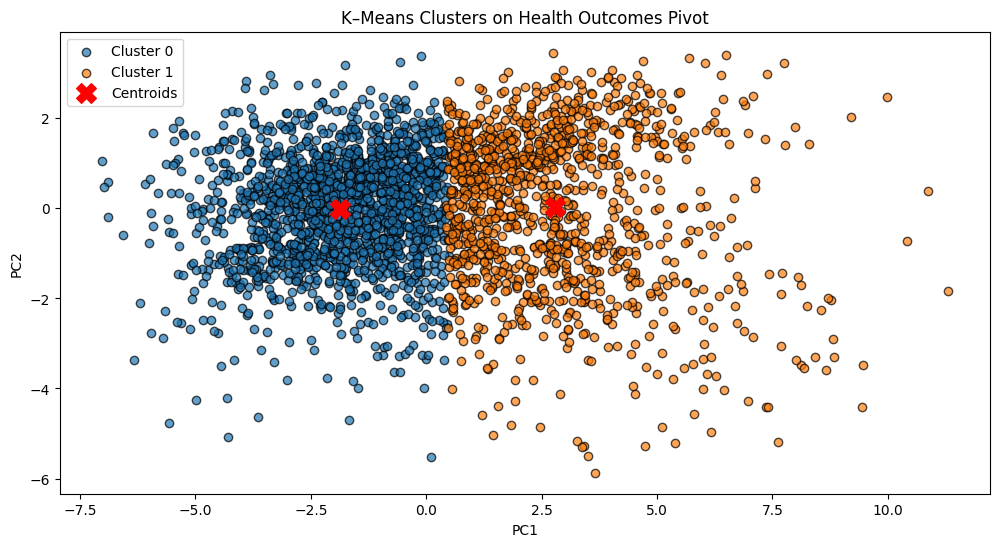

In [15]:
visualize_clusters_PCA(pipe_disease, X_transformed_disease, centroids_disease, clusters_disease, optimal_k_disease, "Health Outcomes")

### Aggregating Cluster Features for Insights

In [16]:
pivot_table_aggregation(clusters_disease, df_pivot_disease, "Health Outcomes", features_disease)

=== Average Feature Values per Cluster (Health Outcomes) ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,11.15,12.88,24.56,6.48,7.18,5.95,10.50,23.19,9.79,29.83,29.61,35.89,3.03
1,19.20,21.22,28.67,9.22,6.87,7.33,11.40,26.06,13.18,37.09,32.24,41.26,4.05


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,-3.23,-3.35,-1.65,-1.10,0.12,-0.55,-0.36,-1.15,-1.36,-2.92,-1.06,-2.16,-0.41
1,4.81,4.99,2.45,1.64,-0.18,0.82,0.54,1.71,2.03,4.34,1.57,3.21,0.61


We can gather the following insights from our **two** clusters on health outcomes and poverty levels:

#### 🔍 **Cluster 0: Lower-Poverty, Better Health Outcomes**
- **BP_ Total% is 11.15**, which is **3.23 percentage points below the national average** — indicating this cluster contains **counties with relatively low poverty rates**.
- Health outcomes are generally better than average:
  - **Obesity (35.89%)**, **diabetes (9.79%)**, **high blood pressure (29.83%)**, and **all teeth lost (12.88%)** are all **lower than the national averages**.
  - This cluster is **below the mean** in nearly every major health condition, suggesting healthier populations and potentially better healthcare access.
  - **Cancer** doesn't follow this trend, as evidenced by our **Project Part 2** analysis that it doesn't have a positive correlation with increasing poverty levels.

---

#### 🔍 **Cluster 1: Higher-Poverty, Poorer Health Outcomes**
- **BP_ Total% is 19.20**, which is **4.81 percentage points above the national average** — showing this cluster includes **counties with significantly higher poverty levels**.
- Health outcomes are worse across the board:
  - Higher rates of **obesity (41.26%)**, **diabetes (13.18%)**, **tooth loss (21.22%)**, and **stroke (4.05%)**.
  - This cluster is **consistently above the overall mean** in almost all categories, showing clear signs of health disparities.
  - **Cancer**, again, doesn't follow this trend.

---

#### 📌 **Key Takeaway**
- These results clearly separate counties into two groups that reflect **socioeconomic and health divides**.
- **Cluster 0** includes healthier, wealthier counties, while **Cluster 1** includes more disadvantaged areas with worse health outcomes.
- This supports previous findings from **Project Part 2** that poverty is deeply tied to public health — and further validates the use of clustering to uncover structural patterns in population health data.

## 2️⃣ Clustering on Health Risk Behaviors Pivot Table

**Health Risk Behaviors** is a primary category referred to in our second research question:

*What **health risk behaviors** are most prevalent in counties with higher poverty rates and do these behaviors correlate with disease prevalence*

Pivot table we'll be using for analysis: **Health Risk-Behaviors as columns alongside Total Poverty Percentages for each US County. `df_pivot_behav`.**

### Preprocess data using pipeline.

In [17]:
X_transformed_behav, features_behav, pipe_behav = preprocess_data(df_pivot_behav, "Health Risk Behaviors")


== Analysis of Health Risk Behaviors ==
Optimal number of PCA components (Health Risk Behaviors): 3
Variance retained (Health Risk Behaviors): 91.79%


The optimal number of principal components needed to retain meaningful information from the original data is **three**. This means that instead of working with all original health risk behavior variables, we can reduce the dataset to just three new dimensions (components) without losing much important information. Specifically, these three components capture **91.79% of the total variance in the original data** — a strong indication that most of the underlying patterns and structure are preserved.

For n_clusters = 2, silhouette score (outcomes) = 0.419
For n_clusters = 3, silhouette score (outcomes) = 0.321
For n_clusters = 4, silhouette score (outcomes) = 0.270
For n_clusters = 5, silhouette score (outcomes) = 0.271
For n_clusters = 6, silhouette score (outcomes) = 0.247
For n_clusters = 7, silhouette score (outcomes) = 0.254
For n_clusters = 8, silhouette score (outcomes) = 0.250
For n_clusters = 9, silhouette score (outcomes) = 0.253
For n_clusters = 10, silhouette score (outcomes) = 0.259
For n_clusters = 11, silhouette score (outcomes) = 0.250
For n_clusters = 12, silhouette score (outcomes) = 0.244
For n_clusters = 13, silhouette score (outcomes) = 0.240
For n_clusters = 14, silhouette score (outcomes) = 0.249
For n_clusters = 15, silhouette score (outcomes) = 0.246
Optimal number of clusters (Health Outcomes): 2


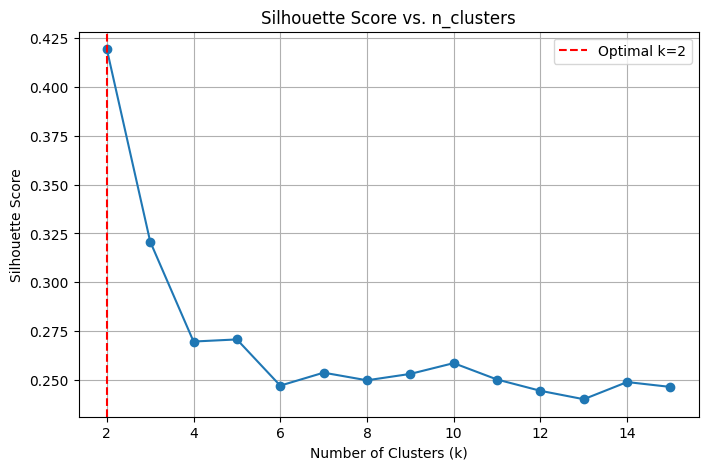

In [18]:
optimal_k_behav = silhouette_analysis(X_transformed_behav)

Among all tested values of k from **2 to 15**, the highest silhouette score was **0.419 when using 2 clusters**, making it the optimal number of clusters for this dataset. As k increases, the silhouette scores slightly decrease and remain relatively low and stable, suggesting that adding more clusters does not significantly improve the grouping and may even lead to overlapping or less distinct clusters.

### Retrieving K-Means Centroids & Clusters

In [19]:
centroids_behav, clusters_behav = perform_k_means_clustering(optimal_k_behav, X_transformed_behav)

k-Means Silhouette Score (Health Outcomes, k=2): 0.419


### Visualization of K–Means Clusters in PCA Space

Visualization PCA Explained Variance Ratio (Health Risk Behaviors): [0.76124468 0.14642474]


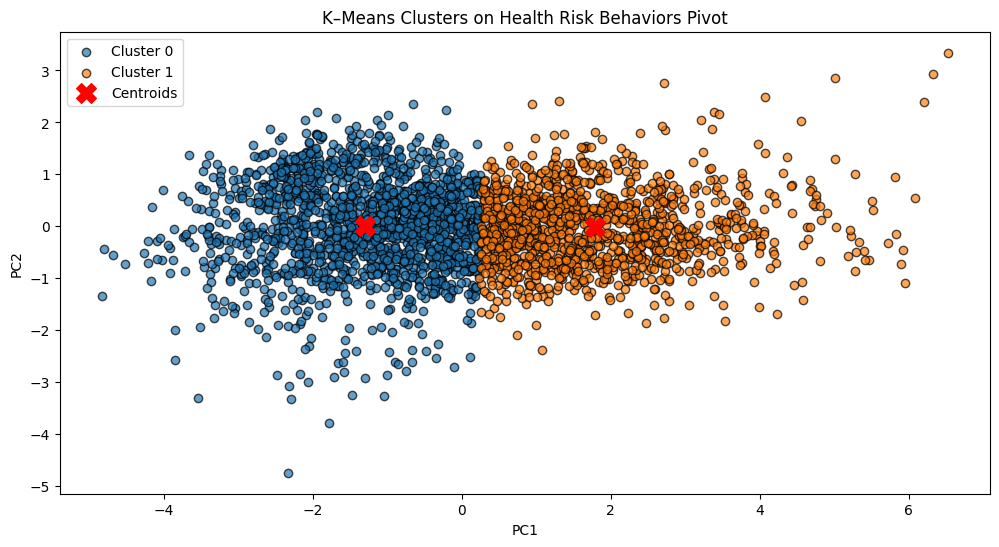

In [20]:
visualize_clusters_PCA(pipe_behav, X_transformed_behav, centroids_behav, clusters_behav, optimal_k_behav, "Health Risk Behaviors")

### Aggregating Cluster Features for Insights

In [21]:
pivot_table_aggregation(clusters_behav, df_pivot_behav, "Health Risk Behaviors", features_behav)

=== Average Feature Values per Cluster (Health Risk Behaviors) ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,10.98,20.24,15.87,23.19,34.97
1,19.09,16.68,21.05,31.02,40.64


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,-3.41,1.50,-2.18,-3.29,-2.39
1,4.70,-2.07,3.00,4.54,3.29


From our **two** clusters on health risk behaviors and poverty levels, we can infer the following:

---

#### 🔍 **Cluster 0: Lower-Poverty, Healthier Behaviors**
- **BP_ Total% is 10.98**, which is **3.41 points below the national average**, identifying this group as **relatively low-poverty counties**.
- These counties show generally **healthier behavior patterns**:
  - Lower levels of **physical inactivity (23.19%)**, **smoking (15.87%)**, and **short sleep (34.97%)**.
  - Interestingly, **binge drinking is slightly above average (20.24%)**, which aligns with prior findings in **Project Part 2** that this behavior may be more common in wealthier areas.

---

#### 🔍 **Cluster 1: Higher-Poverty, Riskier Behaviors**
- **BP_ Total% is 19.09**, or **4.70 points above the national average**, marking this group as counties with **higher poverty levels**.
- These counties exhibit **more concerning behavioral patterns**:
  - Higher rates of **smoking (21.05%)**, **physical inactivity (31.02%)**, and **short sleep (40.64%)**, all of which are well above the national mean.
  - **Binge drinking is lower than average (16.68%)**, reinforcing the earlier observation in **Project Part 2** that it may not follow typical poverty trends.

---

#### 📌 **Key Takeaway**
- The clustering analysis reveals a **clear divide between counties based on poverty level and behavior-related health risks**.
- **Cluster 0** counties are generally healthier and more affluent, while **Cluster 1** shows strong associations between **poverty and negative health behaviors** like smoking, inactivity, and poor sleep.
- These findings emphasize the importance of addressing **behavioral health inequalities** in high-poverty communities through appropriate interventions.

## 3️⃣ Clustering on Racial Disease Pivot Table

**Racial Groups** and **Health Outcomes** (health disparities) are primary features referred to in our third research question:

*How do poverty rates correlate with **health disparities** among **people of color** across different states?* 

Pivot table we'll be using for analysis: **Health Outcomes as columns alongside Racial Poverty Percentages for each US County `df_pivot_racial`.**

### Preprocess data using pipeline.

In [22]:
X_transformed_racial, features_racial, pipe_racial = preprocess_data(df_pivot_racial, "Racial Group Poverty & Disease")


== Analysis of Racial Group Poverty & Disease ==
Optimal number of PCA components (Racial Group Poverty & Disease): 8
Variance retained (Racial Group Poverty & Disease): 91.94%


The optimal number of principal components needed to retain meaningful information from the original data is **eight**. This means that instead of working with all original health outcome variables, we can reduce the dataset to eight new dimensions (components) without losing much important information. Specifically, these eight components capture **91.94% of the total variance in the original data**, and this is the highest number of PCA components across the three clustering analysis.

### Silhouette Analysis for k–Means Clustering

For n_clusters = 2, silhouette score (outcomes) = 0.309
For n_clusters = 3, silhouette score (outcomes) = 0.188
For n_clusters = 4, silhouette score (outcomes) = 0.186
For n_clusters = 5, silhouette score (outcomes) = 0.166
For n_clusters = 6, silhouette score (outcomes) = 0.148
For n_clusters = 7, silhouette score (outcomes) = 0.156
For n_clusters = 8, silhouette score (outcomes) = 0.149
For n_clusters = 9, silhouette score (outcomes) = 0.157
For n_clusters = 10, silhouette score (outcomes) = 0.150
For n_clusters = 11, silhouette score (outcomes) = 0.142
For n_clusters = 12, silhouette score (outcomes) = 0.144
For n_clusters = 13, silhouette score (outcomes) = 0.136
For n_clusters = 14, silhouette score (outcomes) = 0.137
For n_clusters = 15, silhouette score (outcomes) = 0.137
Optimal number of clusters (Health Outcomes): 2


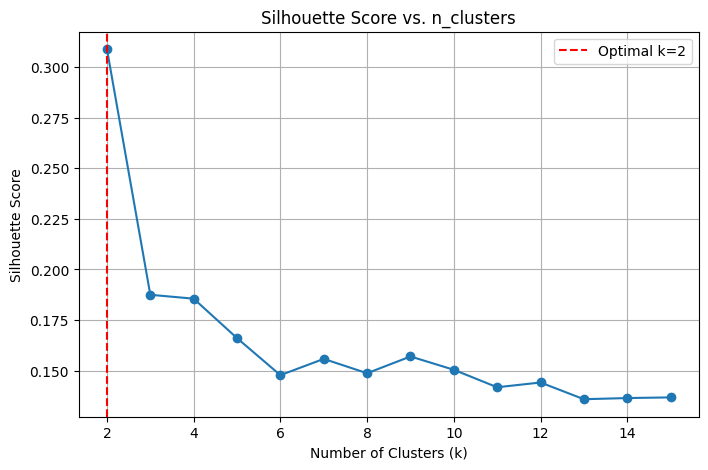

In [23]:
optimal_k_racial = silhouette_analysis(X_transformed_racial)

Among all tested values of k from **2 to 15**, the highest silhouette score was **0.309 when using 2 clusters**, making it the optimal number of clusters for this dataset. As k increases, the silhouette scores slightly decrease and remain relatively low and stable, suggesting that adding more clusters does not significantly improve the grouping and may even lead to overlapping or less distinct clusters.

### Retrieving K-Means Centroids & Clusters

In [24]:
centroids_racial, clusters_racial = perform_k_means_clustering(optimal_k_racial, X_transformed_racial)

k-Means Silhouette Score (Health Outcomes, k=2): 0.309


### Visualization of K–Means Clusters in PCA Space

Visualization PCA Explained Variance Ratio (Racial Group Poverty & Disease): [0.5268897  0.14615987]


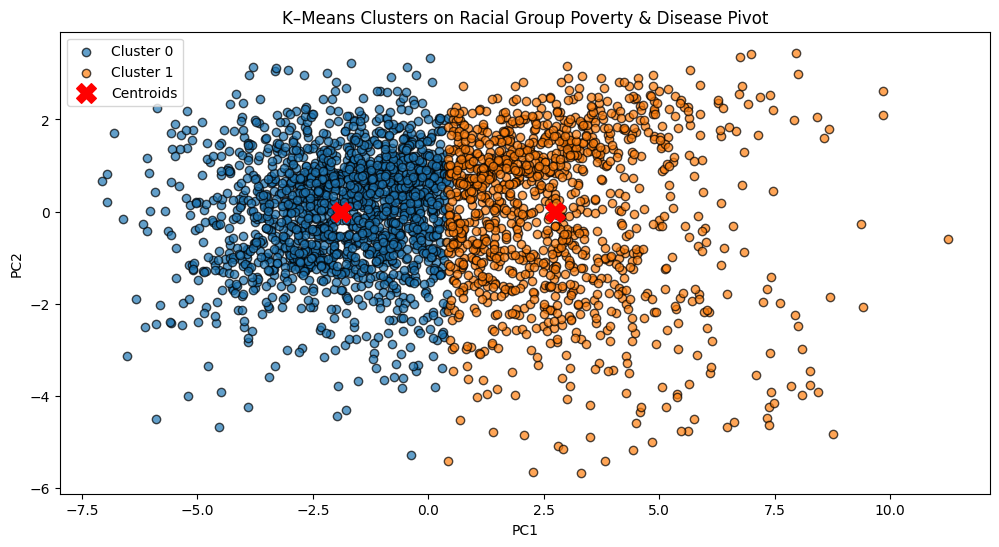

In [25]:
visualize_clusters_PCA(pipe_racial, X_transformed_racial, centroids_racial, clusters_racial, optimal_k_racial, "Racial Group Poverty & Disease")

### Aggregating Cluster Features for Insights

In [26]:
pivot_table_aggregation(clusters_racial, df_pivot_racial, "Racial Group Poverty & Disease", features_racial)

=== Average Feature Values per Cluster (Racial Group Poverty & Disease) ===


Health_Measure,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,,,,
0,21.99,11.17,17.49,9.50,12.89,24.52,6.45,7.17,5.94,10.49,23.14,9.80,29.84,29.62,35.88,3.03
1,30.61,14.11,25.82,14.95,21.12,28.68,9.23,6.89,7.33,11.41,26.11,13.13,37.01,32.20,41.23,4.03


=== Difference from Overall Mean ===


Health_Measure,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,,,,
0,-3.50,-1.19,-3.38,-2.21,-3.34,-1.69,-1.13,0.11,-0.56,-0.37,-1.20,-1.35,-2.91,-1.05,-2.17,-0.41
1,5.12,1.74,4.94,3.23,4.89,2.47,1.65,-0.16,0.82,0.55,1.76,1.98,4.26,1.53,3.18,0.60


From our **two** clusters on health outcomes and racial poverty levels, we can infer the following:

---

#### 🔍 **Cluster 0: Lower Racial Poverty, Better Health Outcomes**
- This cluster includes counties with **consistently lower poverty rates** across all major racial groups:
  - **African American poverty**: 21.99% (−3.50 points below national average)  
  - **Asian poverty**: 11.17% (−1.19)  
  - **Hispanic or Latino poverty**: 17.49% (−3.38)  
  - **White poverty**: 9.50% (−2.21)
- Health outcomes are similarly more favorable:
  - Lower rates of **obesity (35.88%)**, **diabetes (9.80%)**, **stroke (3.03%)**, and **tooth loss (12.89%)** compared to the overall dataset.
- These counties likely benefit from **lower structural inequality**, better access to healthcare, and healthier living conditions across diverse communities.

---

#### 🔍 **Cluster 1: Higher Racial Poverty, Poorer Health Outcomes**
- In this group, **poverty is elevated across all racial groups**:
  - **African American poverty**: 30.61% (+5.12 points above average)  
  - **Asian poverty**: 14.11% (+1.74)  
  - **Hispanic or Latino poverty**: 25.82% (+4.94)  
  - **White poverty**: 14.95% (+3.23)
- Health outcomes are worse across the board:
  - Higher prevalence of **obesity (41.23%)**, **diabetes (13.13%)**, **high blood pressure (37.01%)**, **stroke (4.03%)**, and **all teeth lost (21.12%)**.
- This cluster reflects areas with **more severe racialized poverty** and its downstream effects on health — particularly among **African American and Hispanic** populations, but also affecting **Asian and White** groups.

---

#### 📌 **Key Takeaway**
- Across both clusters, the trend is clear: **as racial group poverty increases, health outcomes worsen**.
- While African American and Hispanic poverty gaps are more pronounced, Asian and White populations also experience notable disparities when poverty is elevated.

## Agglomerative Clustering for State-Level Data

So far, we have only seen a confirmation of our analysis from our previous **Project Part 2.** Let's try to do something different and cluster on **State-Level** data for all of our pivot tables. Similar to our **Homework 6,** we will use 4 principal components to reduce dimensionality, and compare results between **3 and 5 clusters**. 

### Health Outcome Pivot Table

In [27]:
def cluster_and_plot_states(df_pivot, pipe, n_clusters=3, n_components=4, linkage_method='average',):
   
    # Group and prepare data
    df_grouped = df_pivot.groupby("State", as_index=False).mean(numeric_only=True)
    group_features = [col for col in df_grouped.columns if col not in ["State", "Cluster"]]
    X_group = pipe.transform(df_grouped[group_features])
    
    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_group)
    explained_var = pca.explained_variance_ratio_
    total_var = explained_var.sum() * 100
    print(f"\n🔍 PCA ({n_clusters} clusters): Variance retained in first {n_components} components = {total_var:.2f}%")
    
    # Clustering
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    cluster_labels = agg.fit_predict(X_pca)
    
    # Plot PCA results
    plt.figure(figsize=(8, 6))

    for cluster_id in sorted(set(cluster_labels)):
        cluster_mask = cluster_labels == cluster_id
        plt.scatter(
            X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
            label=f"Cluster {cluster_id}",
            s=100, edgecolor='k'
        )

    # Add state labels
    for i, label in enumerate(df_grouped["State"]):
        plt.text(X_pca[i, 0] + 0.1, X_pca[i, 1], label, fontsize=8)

    plt.title(f"Agglomerative Clustering ({n_clusters} Clusters) on PCA-reduced Data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Aggregate 
    pivot_table_aggregation(
        clusters=cluster_labels,
        df_pivot=df_grouped.copy(),  # send a copy so we don’t overwrite df_grouped
        target=f"{n_clusters} Clusters",
        features=group_features
    )


🔍 PCA (3 clusters): Variance retained in first 4 components = 97.57%


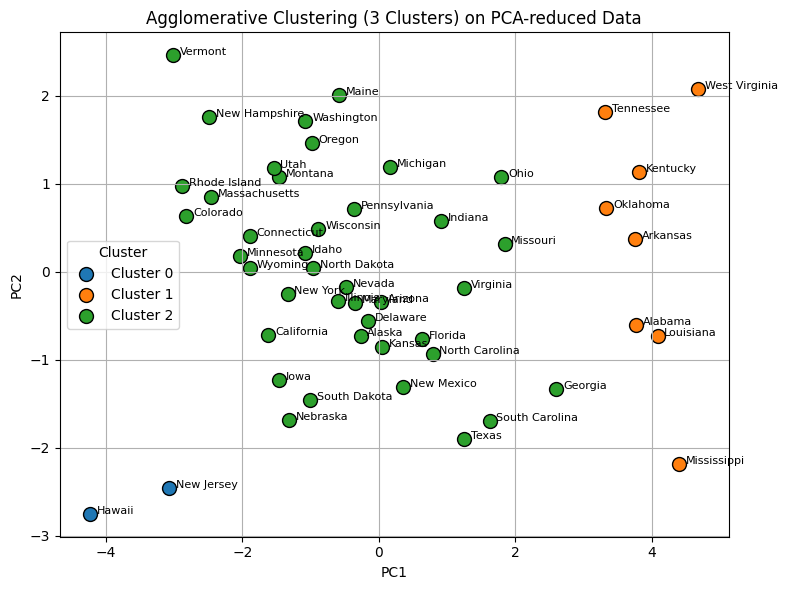

=== Average Feature Values per Cluster (3 Clusters) ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,10.29,9.59,20.93,4.78,5.99,5.22,9.82,16.88,9.53,26.19,28.45,28.10,2.96
1,18.70,21.06,29.92,9.37,6.97,7.37,11.54,27.76,13.26,38.26,32.49,41.18,3.99
2,12.72,14.28,24.94,6.79,7.13,6.12,11.02,23.62,10.01,30.11,29.41,35.57,3.21


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,-3.28,-5.59,-4.64,-2.34,-1.07,-1.06,-1.24,-7.13,-0.98,-5.09,-1.42,-8.07,-0.36
1,5.13,5.88,4.34,2.25,-0.09,1.09,0.48,3.75,2.75,6.98,2.61,5.01,0.66
2,-0.86,-0.90,-0.64,-0.33,0.07,-0.16,-0.03,-0.39,-0.50,-1.17,-0.46,-0.60,-0.11


In [28]:
# For 3-cluster solution
cluster_and_plot_states(df_pivot_disease, pipe_disease, 3)

We have now completed a **3-cluster K-Means analysis** performed at the **state level**, rather than the county level. Each cluster groups states based on similarities in average poverty rates and health outcomes. Let's take a look at each of them!

---

#### 🔍 **Cluster 0: Healthiest & Wealthiest States** *(Hawaii, New Jersey)*
- **BP_ Total% (10.29%)** is **well below the national average**, indicating **lower poverty rates**.
- These states also have the **lowest prevalence of almost every major health condition**:
  - **All teeth lost (9.59%)**, **diabetes (9.53%)**, **obesity (28.10%)**, and **depression (16.88%)** are all **significantly below average**.
  - These states are **5.09 points below the national mean in high blood pressure** and **8.07 points below in obesity** — strong indicators of better chronic disease management.
- While **Hawaii** and **New Jersey** may not be the richest states according to our previous Project Part 2 analysis, they may have better health outcomes, which is why they have their own clusters. This is interesting because we did not find this relationship on our own.

---

#### 🔍 **Cluster 1: Most Disadvantaged States**
- **BP_ Total% (18.70%)** is **substantially above the national average** (+5.13).
- These states have the **highest burden of disease** across nearly all outcomes:
  - **Obesity (41.18%)**, **diabetes (13.26%)**, and **all teeth lost (21.06%)** are all **significantly higher than average**.
  - They also experience the **highest levels of depression (27.76%)** and **arthritis (29.92%)**.
- These states likely struggle with **systemic poverty, underfunded healthcare systems, and higher rates of lifestyle-related diseases**.

---

#### 🔍 **Cluster 2: Moderately Affected States** *(Every other state)*
- These states fall somewhere in the middle, with **BP_ Total% (12.72%)**, only slightly below average (−0.86).
- Their health outcomes are **near national averages**, with small deviations in either direction:
  - For example, **obesity (35.57%)** is just slightly below average (−0.60), and **stroke (3.21%)** is close to the overall mean (−0.11).
- This group may include states with **mixed health policies, moderate poverty, and average access to care**, neither strongly advantaged nor severely disadvantaged.

---

#### 📌 **Key Takeaway**
- At the **state level**, clustering reveals a **clear spectrum**:
  - **Cluster 0**: High-income, low-poverty states with excellent health outcomes.
  - **Cluster 1**: High-poverty states facing major public health challenges.
  - **Cluster 2**: States with **moderate poverty and average health indicators**.
- This reinforces the idea that **poverty and poor health go hand in hand**, even when zoomed out to a broader scale.


🔍 PCA (5 clusters): Variance retained in first 4 components = 97.57%


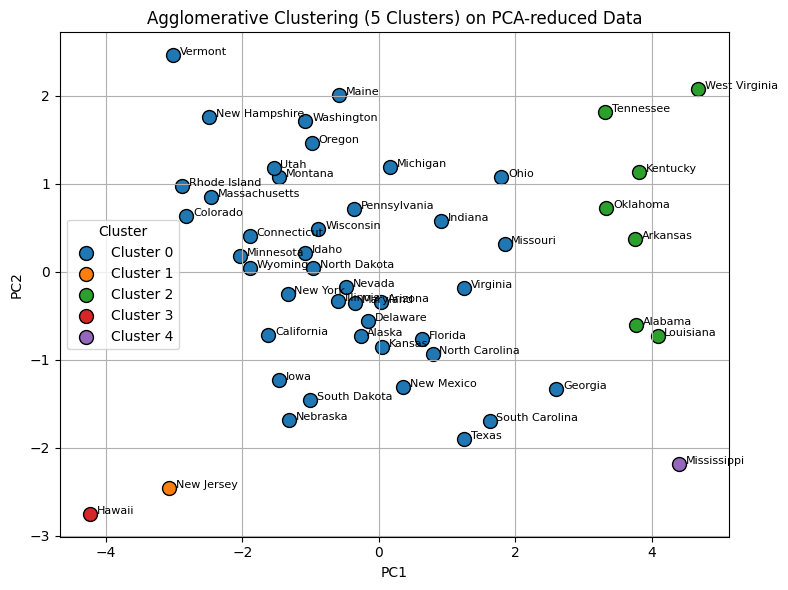

=== Average Feature Values per Cluster (5 Clusters) ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,12.72,14.28,24.94,6.79,7.13,6.12,11.02,23.62,10.01,30.11,29.41,35.57,3.21
1,9.50,9.85,20.80,4.79,6.53,5.26,9.43,17.30,8.96,28.14,31.35,30.55,2.73
2,18.23,20.81,29.91,9.42,7.07,7.38,11.64,28.65,13.08,37.55,32.64,40.81,3.91
3,11.08,9.32,21.06,4.76,5.46,5.18,10.20,16.46,10.10,24.24,25.56,25.64,3.20
4,21.99,22.75,29.98,8.97,6.24,7.31,10.81,21.51,14.53,43.26,31.39,43.74,4.54


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,
0,-0.86,-0.90,-0.64,-0.33,0.07,-0.16,-0.03,-0.39,-0.50,-1.17,-0.46,-0.60,-0.11
1,-4.07,-5.33,-4.77,-2.33,-0.53,-1.02,-1.62,-6.70,-1.55,-3.14,1.47,-5.61,-0.60
2,4.66,5.64,4.33,2.31,0.01,1.09,0.59,4.64,2.57,6.27,2.77,4.65,0.59
3,-2.50,-5.86,-4.52,-2.36,-1.60,-1.10,-0.86,-7.55,-0.41,-7.04,-4.32,-10.53,-0.12
4,8.41,7.57,4.40,1.85,-0.82,1.03,-0.25,-2.50,4.02,11.98,1.52,7.58,1.22


In [29]:
# For 5-cluster solution
cluster_and_plot_states(df_pivot_disease, pipe_disease, 5)

These clusters don't seem to be as **meaningful** as our **three** cluster solution, therefore, we will **not** be discussing key takeaways.

#### **State-wise Dendogram**

In [30]:
from scipy.cluster.hierarchy import dendrogram

The `linkage_matrix_from_agg` function below creates a linkage matrix from a fitted `AgglomerativeClustering` model in scikit-learn. Since the **Agglomerative Clustering** model doesn’t provide a linkage matrix directly, the function reconstructs it using the model’s `children_` and `distances_` attributes. It calculates how many original data points are in each newly formed cluster and then combines the merge information, distances between clusters, and sample counts into a format compatible with SciPy’s `dendrogram` function. This allows us to visualize the hierarchical clustering as a tree, even though scikit-learn doesn’t include a dendrogram plot by default.

In [31]:
# ------- Helper Function -------
def linkage_matrix_from_agg(model):
    """
    Create a linkage matrix from a fitted AgglomerativeClustering model.
    """
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

Let's create a dendogram with no limit on clusters!

In [32]:
def dendrogram_for_all_states(df_pivot, pipe, pivot_label):
    """
    Groups df_pivot_disease by state (using the mean of numeric values) and plots an overall dendrogram.
    """
    # Group by state using df_pivot_disease.
    df_grouped = df_pivot.groupby("State", as_index=False).mean(numeric_only=True)
    if df_grouped.shape[0] < 2:
        print("Not enough states for overall clustering.")
        return
    # Select feature columns; here we exclude "State", "BP_ Total%", and "Cluster" (if present).
    group_features = [col for col in df_grouped.columns if col not in ["State", "Cluster"]]
    
    # Transform these features using our disease pipeline
    X_group = pipe.transform(df_grouped[group_features])
    
    agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    agg.fit(X_group)
    linkage_mat = linkage_matrix_from_agg(agg)
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Clustering on all States ({pivot_label})")
    dendrogram(linkage_mat, labels=df_grouped["State"].values, color_threshold=40)
    plt.xlabel("State")
    plt.ylabel("Distance")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

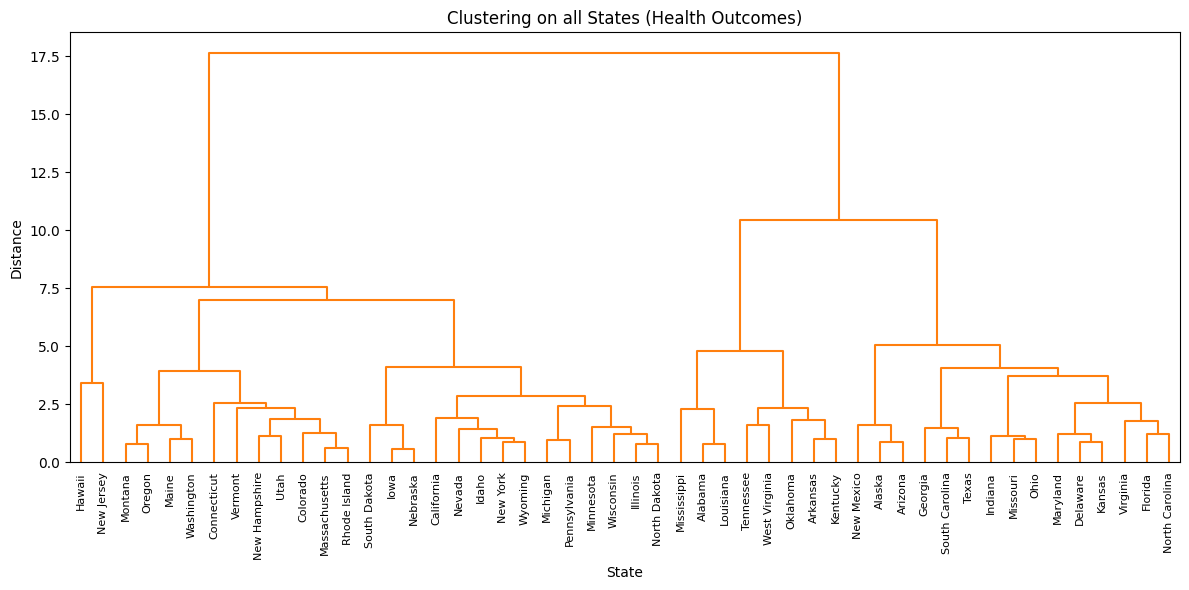

In [33]:
# Show the overall dendrogram for all states:
dendrogram_for_all_states(df_pivot_disease, pipe_disease, "Health Outcomes")

The dendrogram reveals that **Hawaii and New Jersey** form a unique cluster, standing apart from all other states — reflecting their **exceptionally low total poverty rates and strong health outcomes**. At the other end, states like **Mississippi, Louisiana, West Virginia, and Alabama** are tightly grouped, highlighting their **shared high total poverty and the worst health metrics**. A large middle group of states (e.g., **Wisconsin, Pennsylvania, Colorado, Iowa**) clusters closer together, suggesting **moderate poverty levels and relatively balanced health profiles**.

### Health Risk Behavior Pivot Table


🔍 PCA (3 clusters): Variance retained in first 2 components = 93.07%


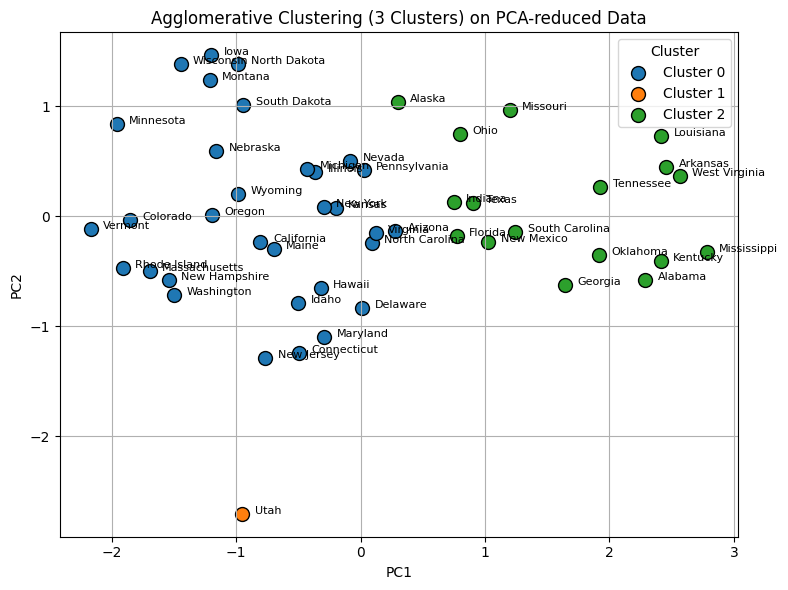

=== Average Feature Values per Cluster (3 Clusters) ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,11.87,19.98,15.61,22.79,35.30
1,10.47,13.24,10.49,19.48,34.61
2,16.96,17.14,20.14,29.48,39.70


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,-1.70,1.10,-1.44,-2.21,-1.48
1,-3.11,-5.63,-6.56,-5.52,-2.17
2,3.39,-1.74,3.09,4.48,2.92


In [34]:
# For 3-cluster solution
cluster_and_plot_states(df_pivot_behav, pipe_behav, 3, 2) # There were less than 4 PCA components overall, hence the 2 PCA Components

Below is a **3-cluster K-Means analysis** conducted at the **state level**, focusing on the relationship between **total poverty** and key **health risk behaviors**. 

---

#### 🔍 **Cluster 1: Low Poverty, Health-Conscious State** *(Utah)*
- **BP_ Total% (10.47%)** is the **lowest across all clusters**, indicating **minimal poverty**.
- This state also reports the **lowest levels of risky behaviors**:
  - **Binge Drinking (13.24%)**, **Smoking (10.49%)**, and **Physical Inactivity (19.48%)** are all **well below national averages**.
- With a drop of over **5 points below average in both smoking and drinking**, this cluster represents Utah as a **state with healthier lifestyles and economic stability**, another key takeaway not uncovered before.

---

#### 🔍 **Cluster 0: Moderately Poor, Moderate Risk States**
- **BP_ Total% (11.87%)** is **slightly below average**, and most behaviors are just marginally above or below the national mean.
  - **Binge Drinking (19.98%)** is slightly elevated (+1.10), but other behaviors like **inactivity (22.79%)** and **smoking (15.61%)** are still fairly controlled.
- These states may be **middle-income regions** where public health initiatives are present but behaviors vary more by population subgroups.

---

#### 🔍 **Cluster 2: High-Poverty, High-Risk States**
- **BP_ Total% (16.96%)** is **well above the national average** (+3.39).
- This group reports the **highest levels of smoking (20.14%)**, **inactivity (29.48%)**, and **short sleep duration (39.70%)**.
- These states may struggle with **resource gaps**, limited health education, or structural issues that lead to **high-risk behaviors**.

---

#### 📌 **Key Takeaway**
- The clustering reveals a clear trend: **as poverty increases, so does the prevalence of unhealthy behaviors**.
- **Utah** tends to have **healthier populations**, while **Cluster 2 (poorer states)** exhibits **concerning levels of behavioral health risks**.


🔍 PCA (5 clusters): Variance retained in first 2 components = 93.07%


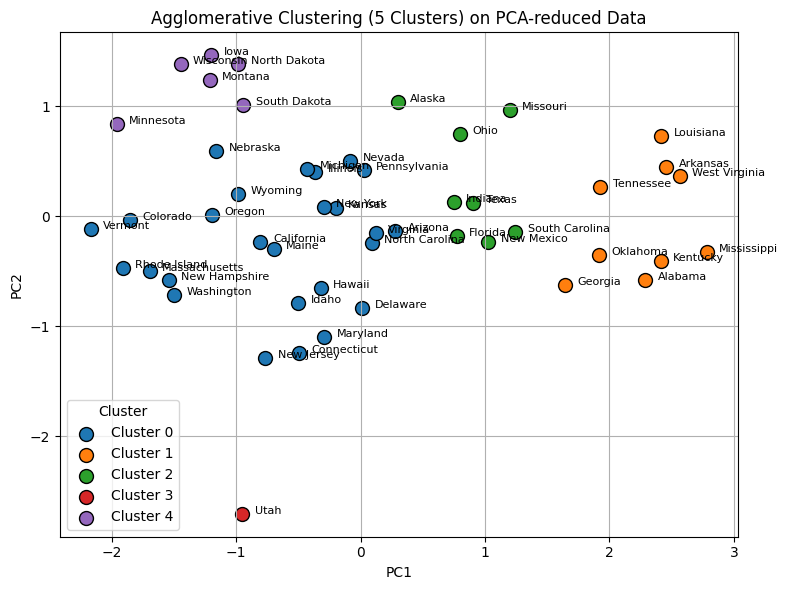

=== Average Feature Values per Cluster (5 Clusters) ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,11.91,19.27,15.21,22.61,35.81
1,18.58,15.97,20.81,31.23,40.84
2,15.14,18.46,19.38,27.52,38.41
3,10.47,13.24,10.49,19.48,34.61
4,11.70,23.05,17.30,23.58,33.06


=== Difference from Overall Mean ===


Health_Measure,BP_ Total%,Binge Drinking,Current Cigarette Smoking,Physical Inactivity,Short Sleep Duration
Cluster,,,,,
0,-1.66,0.39,-1.83,-2.39,-0.97
1,5.01,-2.91,3.77,6.22,4.06
2,1.57,-0.42,2.33,2.52,1.63
3,-3.11,-5.63,-6.56,-5.52,-2.17
4,-1.87,4.17,0.25,-1.42,-3.72


In [35]:
# For 5-cluster solution
cluster_and_plot_states(df_pivot_behav, pipe_behav, 5, 2) # There were less than 4 PCA components overall, hence the 2 PCA Components

Below is a **5-cluster K-Means analysis** at the **state level**, analyzing the relationship between **poverty rates** and key **health risk behaviors**.

---

#### 🔍 **Cluster 3: Healthiest & Wealthiest State** *(Utah)*
- **Lowest poverty rate (10.47%)**, and the **lowest behavioral risk profile** overall:
  - **Binge Drinking (13.24%)**, **Smoking (10.49%)**, and **Inactivity (19.48%)** are all **well below the national average**.
- This cluster likely contains **high-income states with strong health education and access to care**, leading to low-risk lifestyles.

---

#### 🔍 **Cluster 1: Most At-Risk States**
- **Highest poverty (18.58%)**, and the **highest behavioral risk profile**:
  - **Smoking (20.81%)**, **Inactivity (31.23%)**, and **Short Sleep Duration (40.84%)** are **all significantly above average**.
- These states may struggle with **deep-rooted structural inequality** and need **aggressive public health interventions**.

---

#### 🔍 **Cluster 2: Moderately Poor, Above-Average Risk**
- **Moderate poverty (15.14%)**, and **elevated but not extreme** levels of health risk behaviors:
  - **Smoking (19.38%)** and **Inactivity (27.52%)** are slightly above average, while binge drinking is close to average.
- This group may include **working-class states** where poverty and health behavior are both **pressing but manageable**.

---

#### 🔍 **Cluster 0: Balanced but at Slight Risk**
- **Poverty (11.91%)** is slightly below the national average, and risk behaviors are mostly near or just above baseline:
  - Slightly elevated **binge drinking (19.27%)**, but relatively normal levels of inactivity and smoking.
- This group may reflect **middle-income states with mixed outcomes** depending on urban/rural divides or policy investments.

---

#### 🔍 **Cluster 4: High Drinking, Low Poverty**
- A **unique outlier**: **low poverty (11.70%)**, but **very high binge drinking (23.05%)**, well above national average (+4.17).
- Other behaviors are average or below, including the **lowest short sleep duration (33.06%)**.
- This may represent **wealthier states** where **alcohol culture** is common despite otherwise healthy lifestyles.
- This is an **amazing** find because we guessed this relationship in **Project Part 2**.
---

#### 📌 **Key Takeaway**
- Increasing cluster granularity reveals that not all **high-risk behaviors are tied to poverty**.
- **Cluster 4**, for example, shows **high binge drinking despite low poverty**, suggesting cultural or regional influence.
- **Cluster 1** reinforces the traditional view: **poverty drives health risks**.

#### **State-wise Dendogram**

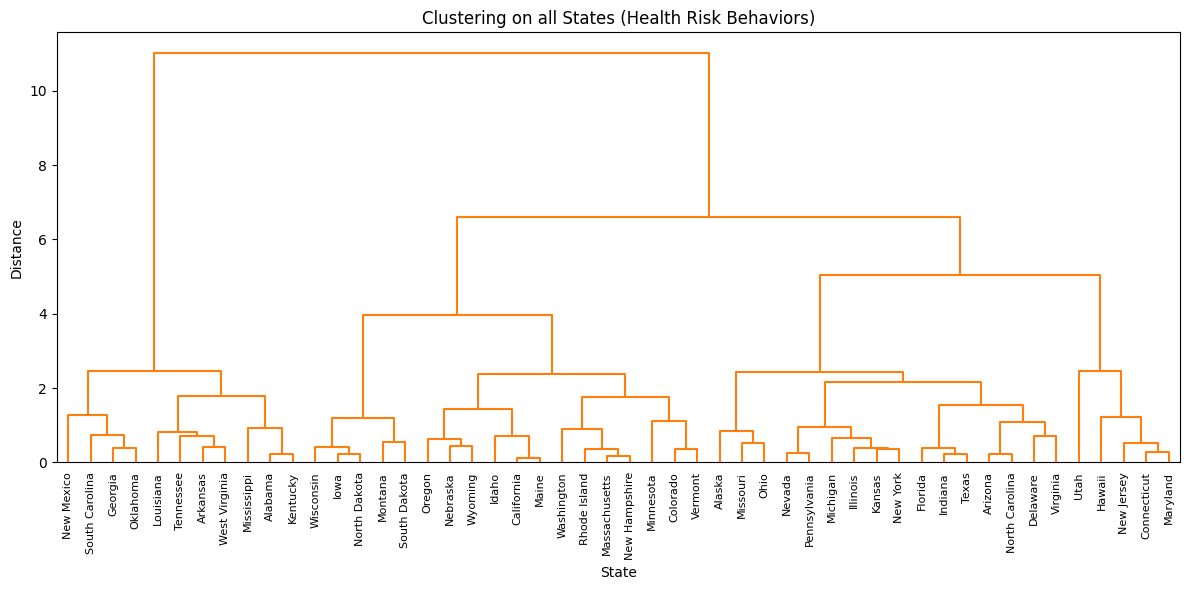

In [36]:
# Show the overall dendrogram for all states:
dendrogram_for_all_states(df_pivot_behav, pipe_behav, "Health Risk Behaviors")

The dendrogram for **health risk behaviors** shows a clear divide between states with **higher-risk lifestyles** and those with **healthier behavior patterns**. States like **New Mexico, South Carolina, Georgia, and Oklahoma** cluster together, indicating they share **elevated rates of risky behaviors** like smoking, inactivity, or poor diet. Meanwhile, states such as **Maryland, Connecticut, New Jersey, and Hawaii** form a separate group, reflecting **low engagement in health risk behaviors**. A large middle cluster includes states like **Oregon, California, and Pennsylvania**, representing **moderate levels** of risk behaviors.

### Racial Poverty and Health Outcomes Pivot Table


🔍 PCA (3 clusters): Variance retained in first 4 components = 96.48%


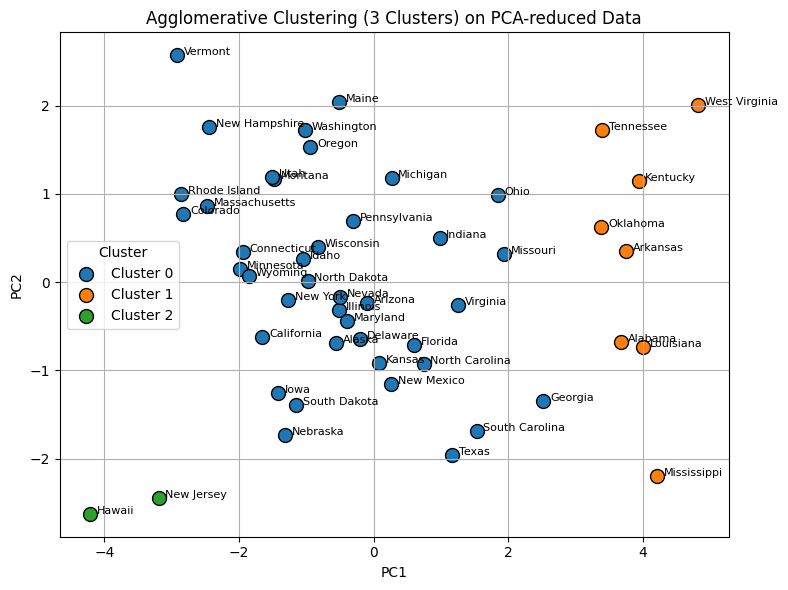

=== Average Feature Values per Cluster (3 Clusters) ===


Health_Measure,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,,,,
0,22.97,12.04,18.80,10.31,14.28,24.94,6.79,7.13,6.12,11.02,23.62,10.01,30.11,29.41,35.57,3.21
1,29.08,14.21,25.98,14.78,21.06,29.92,9.37,6.97,7.37,11.54,27.76,13.26,38.26,32.49,41.18,3.99
2,12.54,5.83,18.99,8.88,9.59,20.93,4.78,5.99,5.22,9.82,16.88,9.53,26.19,28.45,28.10,2.96


=== Difference from Overall Mean ===


Health_Measure,BP_ African American%,BP_ Asian%,BP_ Hispanic or Latino%,BP_ White%,All Teeth Lost,Arthritis,COPD,Cancer (non-skin) or Melanoma,Coronary Heart Disease,Current Asthma,Depression,Diabetes,High Blood Pressure,High Cholesterol,Obesity,Stroke
Cluster,,,,,,,,,,,,,,,,
0,-0.56,-0.10,-1.16,-0.66,-0.90,-0.64,-0.33,0.07,-0.16,-0.03,-0.39,-0.50,-1.17,-0.46,-0.60,-0.11
1,5.55,2.07,6.02,3.82,5.88,4.34,2.25,-0.09,1.09,0.48,3.75,2.75,6.98,2.61,5.01,0.66
2,-10.99,-6.31,-0.97,-2.09,-5.59,-4.64,-2.34,-1.07,-1.06,-1.24,-7.13,-0.98,-5.09,-1.42,-8.07,-0.36


In [37]:
# For 3-cluster solution
cluster_and_plot_states(df_pivot_racial, pipe_racial, 3)

These clusters seem to be almost identical to our **three** cluster solution for **Health Outcomes and Total Poverty**, which suggests that there isn't a big difference between looking at poverty rates separately by race and together as one. We will not be discussing the **five** cluster solution for this reason.

**However**, it is important to note that our cluster analysis **does** show some interesting trends between each racial group.

---

#### 🔍 **Cluster 2: Exceptionally Low African American & Asian Poverty** *(Hawaii, New Jersey)*  
- This cluster stands out due to **very low African American poverty (12.54%)**, deviating **−10.99** from the national mean, and **low Asian poverty (5.83%)**, **−6.31** from the mean.  
-  **Hispanic poverty (18.99%)** is close to the national mean, showing that though other minorities are doing well, there is still a small **racial divide in economic conditions**.  
- Health outcomes are **the best across all clusters**:
  - **Obesity: 28.10%**, **High Blood Pressure: 26.19%**, **Depression: 16.88%**, all significantly **below national averages**.
- The data implies that **broad economic stability among multiple racial groups — especially Black and Asian communities — is associated with better public health**.
---

#### 🔍 **Cluster 1: Deep Multiracial Poverty & the Worst Health Outcomes**  
- This cluster includes states with **widespread racial poverty**, especially:
  - **African American: 29.08% (+5.55)**, **Hispanic: 25.98% (+6.02)**, **White: 14.78% (+3.82)**, **Asian: 14.21% (+2.07)**.
- Every group is affected, particularly in **Black and Latino communities**, suggesting **deep systemic disadvantage** across the population.  
- These states suffer from **the worst health outcomes**:
  - **Obesity: 41.18%**, **Diabetes: 13.26%**, **High Blood Pressure: 38.26%**, **Depression: 27.76%**.
- The convergence of high poverty and poor health in all groups shows that **when economic inequality spans all races, population health severely declines**.

---

#### 🔍 **Cluster 0: Moderate Racial Poverty with Mixed Health Outcomes**  
- This group shows **moderate poverty** across all four groups:
  - African American: 22.97% (−0.56), Asian: 12.04% (−0.10), Hispanic: 18.80% (−1.16), White: 10.31% (−0.66).  
- Health outcomes are **better than average**, though not as strong as Cluster 2:
  - **Obesity: 35.57% (−0.60)**, **High Blood Pressure: 29.41% (−1.42)**, **Diabetes: 10.01% (−1.17)**.

---

#### 📌 **Key Takeaways on Racial Trends**  
- **Cluster 2** demonstrates that **very low poverty among African American, Asian, and White populations** is strongly linked to **excellent health outcomes** — though **Hispanic communities** may still have some poverty.
- **Cluster 1** highlights a **crisis of multiracial poverty**, where all four groups experience **elevated poverty and poor health** — showing the urgent need for **cross-community poverty reduction strategies**.
- **Cluster 0** shows that **modest poverty improvements across racial lines** can stabilize health, even if gains are more subtle.
- Ultimately, **health equity depends on reducing poverty across *all* racial groups**, but special attention is needed for **Black and Latino communities**, who consistently face the **highest poverty and disease burden**.

#### **State-wise Dendogram**

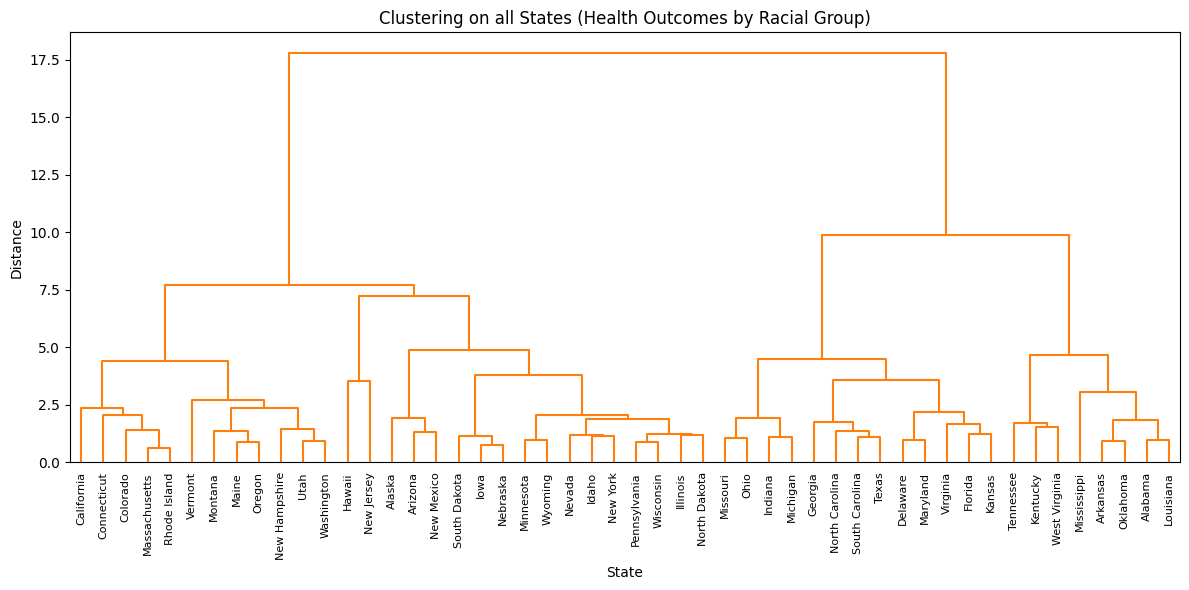

In [38]:
# Show the overall dendrogram for all states:
dendrogram_for_all_states(df_pivot_racial, pipe_racial, "Health Outcomes by Racial Group")

This dendrogram illustrates the clustering of **U.S. states** based on **health outcomes by racial group**, revealing significant geographic patterns in **health equity**. States such as **California**, **Connecticut**, **Massachusetts**, and **Colorado** appear on the left side of the dendrogram, indicating they share more similar—and likely more equitable—**health outcomes across racial groups**. In contrast, states like **Alabama**, **Louisiana**, **Mississippi**, and **Oklahoma** cluster on the far right, suggesting **greater racial disparities** in health outcomes. The middle group of states, including **Iowa**, **Nebraska**, and **Minnesota**, may represent moderate disparities or a mix of patterns. Overall, the visualization highlights that **northern and coastal states** tend to have more **equitable health outcomes by race**, while many **southern states** exhibit **wider gaps**. 

## Reflection and Synthesis

We employed **K-Means Clustering** and **Agglomerative (Hierarchical) Clustering**, both unsupervised learning techniques, to group counties based on similar profiles in health outcomes, health risk behaviors, and racial poverty statistics. These methods were ideal given the continuous nature of our dataset and the absence of predefined class labels. By forgoing classification methods—which we considered but rejected due to the lack of significant results from chi-squared tests from **Project Part 2**—we preserved the continuous variables and avoided arbitrary thresholding.

To prepare the data, we implemented preprocessing pipelines including standardization and **Principal Component Analysis (PCA)** for dimensionality reduction. PCA helped in visualizing the data and identifying the most informative components, retaining over 90% of variance in several feature sets. These transformations enabled more meaningful cluster formation and interpretation.

The clustering results revealed **natural groupings of counties** that shared similar socioeconomic and health profiles. For example, we observed how certain clusters correlated with higher incidences of chronic conditions and poverty levels, while others were defined by lower poverty rates and better health metrics. These findings provided valuable insight into **systemic health disparities** and regional inequalities, particularly as they intersect with race and economic status.

In addition, we uncovered hidden patterns in our data that we hadn't seen before. For example, finding the few **richer** states with the best health outcomes (**Hawaii** and **New Jersey**) and health risk behaviors (**Utah**). In our **5-cluster** hierarchal analysis, we noticed how richer states practiced often practiced binge drinking, reinforcing that binge drinking could be more of an indicator of **wealth** rather than **health outcome**.

For **further analysis**, we could possibly compare all of clustering techniques together, or even try new ones, to uncover more hidden patterns in data.

## Declaration
Generative AI was used to assist with 
- Code formatting
- Refining comments
- Helped with some tough inferences, especially regarding racial poverty